In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


# 1) Data Loading and Initial Exploration

In this section, I load the train and test datasets, review their sizes, columns, datatype information, and basic statistics.  
This helps me to understand the dataset structure and guides preprocessing.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# File paths
TRAIN_PATH = Path("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
TEST_PATH = Path("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")


In [3]:
# Load datasets
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [4]:
# Display dataset sizes
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (116023, 52)
Test shape: (29006, 51)


In [5]:
# Basic info to understand column data types and detect missing values
print("\nTraining data info:")
train.info()

print("\nTest data info:")
test.info()


Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding

In [6]:
# Statistical summary of numeric columns
print("\nTraining data descriptive stats:")
print(train.describe())


Training data descriptive stats:
       purchaseValue         userId   gclIdPresent  sessionNumber  \
count   1.160230e+05  116023.000000  116023.000000  116023.000000   
mean    2.656393e+07   61094.356231       0.037019       2.691311   
std     2.051825e+08   35240.756859       0.188808      10.451613   
min     0.000000e+00       0.000000       0.000000       1.000000   
25%     0.000000e+00   30603.500000       0.000000       1.000000   
50%     0.000000e+00   61014.000000       0.000000       1.000000   
75%     0.000000e+00   91616.500000       0.000000       2.000000   
max     2.312950e+10  122276.000000       1.000000     447.000000   

       totals.visits     sessionId  trafficSource.adwordsClickInfo.page  \
count       116023.0  1.160230e+05                          4281.000000   
mean             1.0  1.493429e+09                             1.019622   
std              0.0  1.528798e+07                             0.174517   
min              1.0  1.470035e+09          

In [7]:

# Display first few rows for initial insight
print("\nSample training data rows:")
print(train.head())


Sample training data rows:
  trafficSource.isTrueDirect  purchaseValue            browser  \
0                        NaN            0.0               Edge   
1                       True            0.0             Chrome   
2                       True            0.0             Chrome   
3                        NaN            0.0  Internet Explorer   
4                       True     88950000.0             Chrome   

         device.screenResolution trafficSource.adContent  \
0  not available in demo dataset                     NaN   
1  not available in demo dataset                     NaN   
2  not available in demo dataset                     NaN   
3  not available in demo dataset                     NaN   
4  not available in demo dataset                     NaN   

  trafficSource.keyword screenSize geoCluster  \
0                   NaN     medium   Region_2   
1                   NaN     medium   Region_3   
2        (not provided)     medium   Region_2   
3                 

In [8]:
# List all columns
print("\nTrain columns:\n", train.columns.tolist())


Train columns:
 ['trafficSource.isTrueDirect', 'purchaseValue', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'trafficSource.adwordsClickInfo.page', 'geoNetwork.metro', 'pageViews', 'locationZone', 'device.mobileDeviceModel', 'trafficSource.referralPath', 'totals.bounces', 'date', 'device.l

# 2) Exploratory Data Analysis (EDA)

Here we analyze the data distributions, missing values, correlations and relationships within the dataset.  
This insight informs data cleaning and feature engineering steps.

We will visualize:
- Missing value percentages per column  
- Distribution of key numeric variables, including the target variable `purchaseValue`  
- Histograms and boxplots for numeric features  
- Correlation heatmap to identify multicollinearity  
- Count of categorical variable levels


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

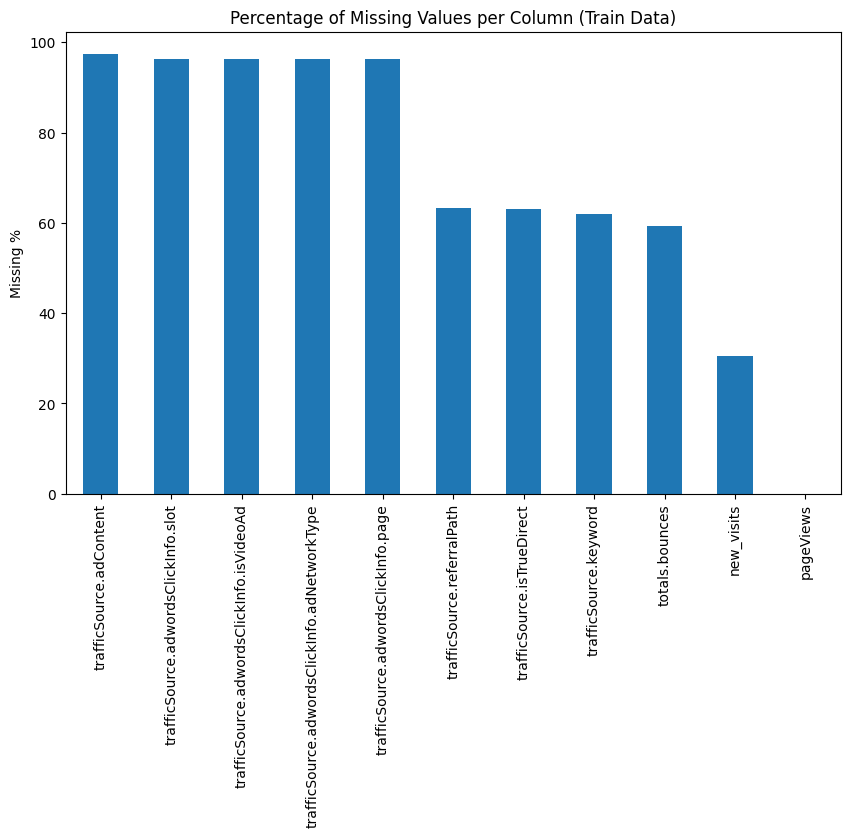

In [10]:
# Missing value percentage per column in train dataset
missing_percent = train.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0]

plt.figure(figsize=(10, 6))
missing_percent.sort_values(ascending=False).plot.bar()
plt.title("Percentage of Missing Values per Column (Train Data)")
plt.ylabel("Missing %")
plt.show()

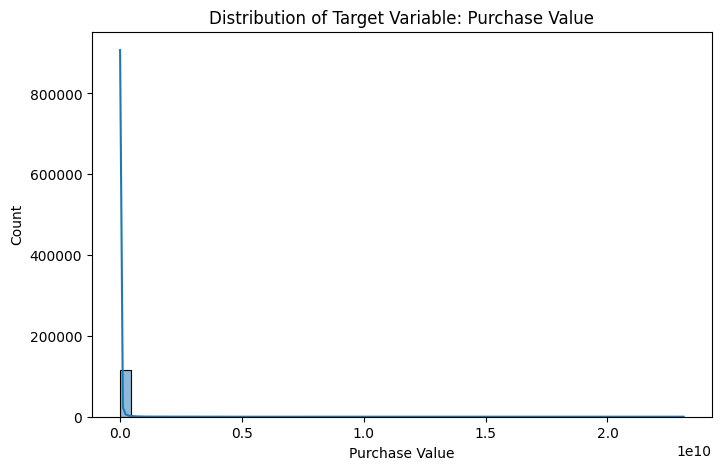

Target variable 'purchaseValue' statistics:
count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64


In [11]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# target variable distributions 
plt.figure(figsize=(8, 5))
sns.histplot(train['purchaseValue'], bins=50, kde=True)
plt.title("Distribution of Target Variable: Purchase Value")
plt.xlabel("Purchase Value")
plt.ylabel("Count")
plt.show()

print("Target variable 'purchaseValue' statistics:")
print(train['purchaseValue'].describe())


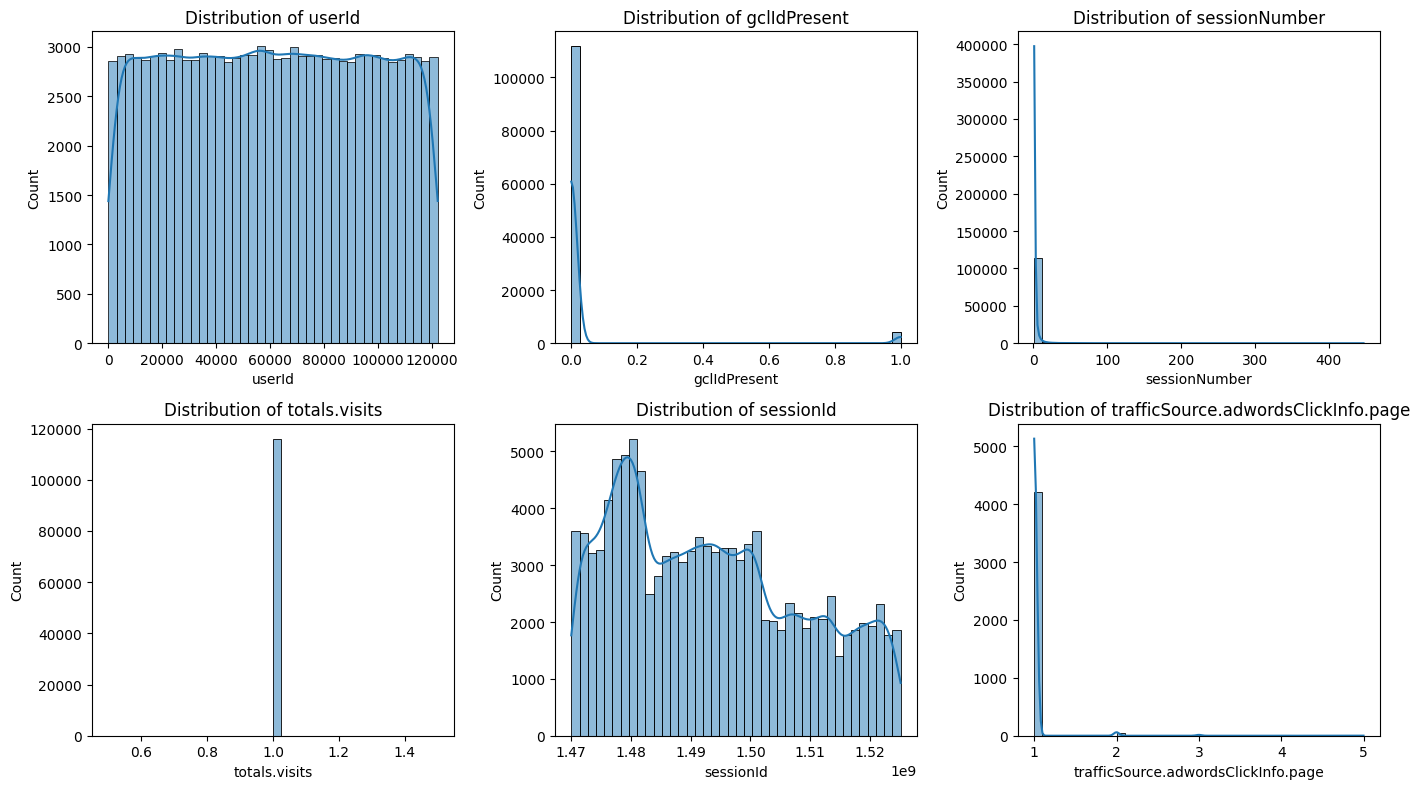

In [12]:
# numeric feature distributions
numeric_features = train.select_dtypes(include=[np.number]).columns.drop('purchaseValue')

plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_features[:6], 1):  # visualize first 6 numeric features as sample
    plt.subplot(2, 3, i)
    sns.histplot(train[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
plt.show()


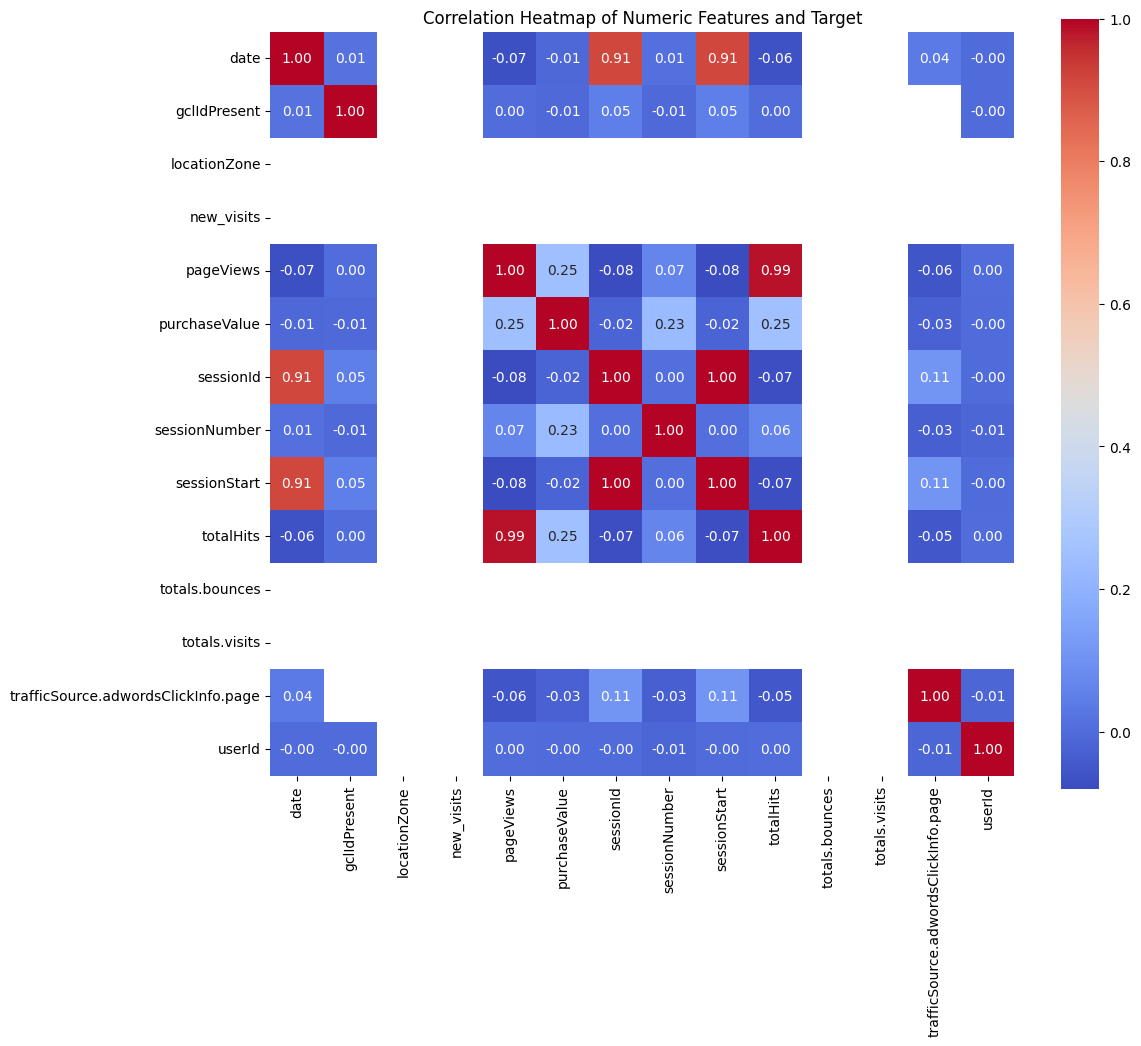

In [13]:
# correlation heatmap of numeric features + purchase_value
plt.figure(figsize=(12, 10))
corr = train[numeric_features.union(['purchaseValue'])].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap of Numeric Features and Target")
plt.show()


In [14]:
# count of categorical levels for a sample of categorical features
cat_features = train.select_dtypes(include=['object']).columns

for col in cat_features[:5]:  # first 5 categorical columns sample
    print(f"\nValue counts for '{col}':")
    print(train[col].value_counts().head(10))  # top 10 frequent categories shown



Value counts for 'trafficSource.isTrueDirect':
trafficSource.isTrueDirect
True    42890
Name: count, dtype: int64

Value counts for 'browser':
browser
Chrome               84508
Safari               19184
Firefox               4031
Internet Explorer     2155
Android Webview       1472
Edge                  1216
Safari (in-app)        793
Opera Mini             733
Samsung Internet       563
Opera                  548
Name: count, dtype: int64

Value counts for 'device.screenResolution':
device.screenResolution
not available in demo dataset    116023
Name: count, dtype: int64

Value counts for 'trafficSource.adContent':
trafficSource.adContent
Google Merchandise Store          1410
Google Merchandise Collection      651
Display Ad created 3/11/14         135
Placement Accessores 300 x 250     114
Google Online Store                104
Smart display ad - 8/17/2017        87
Full auto ad IMAGE ONLY             61
Ad from 12/13/16                    50
Official Google Merchandise         

# 3) Data Preprocessing and Cleaning

- Drop columns with >90% missing values as they provide little information.  
- Fill remaining missing numeric values with 0, and categorical NaNs with string 'missing'.  
- Remove columns with only a single unique value to avoid uninformative features.


In [15]:
# Identify columns with >90% missing values
null_summary = train.isnull().sum().to_frame('Missing Count')
null_summary['Missing %'] = (null_summary['Missing Count'] / len(train)) * 100
high_null_cols = null_summary[null_summary['Missing %'] > 90].index.tolist()

print("Dropping columns with >90% missing values:", high_null_cols)


Dropping columns with >90% missing values: ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.page']


In [16]:
# Drop such columns from train and test
train.drop(columns=high_null_cols, inplace=True)
test.drop(columns=[col for col in high_null_cols if col in test.columns], inplace=True)

In [17]:
# Separate numeric and categorical features
num_cols = train.select_dtypes(include=[np.number]).columns.drop('purchaseValue')
obj_cols = train.select_dtypes(include=['object']).columns

In [18]:
# Fill missing values
train[num_cols] = train[num_cols].fillna(0)
test[num_cols] = test[num_cols].fillna(0)
train[obj_cols] = train[obj_cols].fillna('missing')
test[obj_cols] = test[obj_cols].fillna('missing')

In [19]:
# Drop columns with single unique value
single_val_cols = [c for c in train.columns if train[c].nunique() == 1]
print("Dropping single unique valued columns:", single_val_cols)
train.drop(columns=single_val_cols, inplace=True)
test.drop(columns=[col for col in single_val_cols if col in test.columns], inplace=True)

Dropping single unique valued columns: ['device.screenResolution', 'screenSize', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'totals.visits', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'socialEngagementType', 'locationZone', 'device.mobileDeviceModel', 'device.language', 'device.browserVersion', 'device.screenColors']


# 4) Feature Engineering

We add the following features:
- `userAveragePurchase`: average purchase value per user.  
- `pages_per_hit`: engagement metric indicating average pages viewed per hit (pageViews / totalHits).  
- `is_new_visitor`: binary flag, 1 if new visit, else 0.


In [20]:
# Compute average purchase by user
user_avg = train.groupby('userId')['purchaseValue'].mean().rename('userAveragePurchase')


In [21]:
# Merge user average purchase feature into datasets
train = train.merge(user_avg, on='userId', how='left')
test = test.merge(user_avg, on='userId', how='left')

In [22]:
# Fill NaNs introduced by merge (new users in test)
train['userAveragePurchase'].fillna(0, inplace=True)
test['userAveragePurchase'].fillna(0, inplace=True)

In [23]:
# Create engagement features
train['pages_per_hit'] = train['pageViews'] / train['totalHits'].replace(0, np.nan)
test['pages_per_hit'] = test['pageViews'] / test['totalHits'].replace(0, np.nan)
train['pages_per_hit'].fillna(0, inplace=True)
test['pages_per_hit'].fillna(0, inplace=True)

train['is_new_visitor'] = train['new_visits'].apply(lambda x: 1 if x > 0 else 0)
test['is_new_visitor'] = test['new_visits'].apply(lambda x: 1 if x > 0 else 0)

# 5) Categorical Encoding

Encode all categorical columns using OrdinalEncoder while handling unseen categories by encoding them as -1 in test data.


In [24]:
from sklearn.preprocessing import OrdinalEncoder

In [25]:
# Identify categorical columns again post preprocessing
cat_cols = train.select_dtypes(include="object").columns

In [26]:
# Ensure all categorical columns are string type
for col in cat_cols:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

In [27]:
# Setup and apply ordinal encoding with unknown category handling
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train[cat_cols] = ordinal_encoder.fit_transform(train[cat_cols])
test[cat_cols] = ordinal_encoder.transform(test[cat_cols])

In [28]:
# Align columns and prepare training and test sets
train = train.sort_index(axis=1)
test = test.reindex(columns=train.columns.drop(['purchaseValue']), fill_value=0)

X_train = train.drop(columns=["purchaseValue", "sessionId"])
y_train = train["purchaseValue"]
X_test = test.drop(columns=["sessionId"])

# 6) Model Training and Ensemble

Train three regression models with hyperparameter tuning using cross-validation:  
1. XGBoost Regressor using GridSearchCV  
2. Random Forest Regressor using RandomizedSearchCV  
3. LightGBM Regressor using RandomizedSearchCV

Finally, create a simple average ensemble of the predictions from these models.


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from scipy.stats import randint, uniform

In [30]:
# 1) Split train data into training and validation subsets (80-20 split)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training subset shape: {X_train_split.shape}")
print(f"Validation subset shape: {X_val.shape}")

Training subset shape: (92818, 31)
Validation subset shape: (23205, 31)


In [31]:
# --- Model 1: XGBoost ---
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_param_grid = {
    "n_estimators": [275, 300],
    "max_depth": [5, 7],
    "learning_rate": [0.05, 0.07],
    "subsample": [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, scoring="r2", cv=5, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
print(f"\n✅ XGBoost Best R² CV on training subset: {xgb_grid.best_score_:.4f}")
print(f"✅ XGBoost Best params: {xgb_grid.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ XGBoost Best R² CV on training subset: 0.6660
✅ XGBoost Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}


In [32]:
# --- Model 2: Random Forest ---
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_param_grid = {
    "n_estimators": [100],        # list with one element
    "max_depth": [10],
    "min_samples_split": [2]
}

rf_grid = GridSearchCV(
    rf_model,
    param_grid=rf_param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)
rf_grid.fit(X_train, y_train)

print(f"\n✅ RF Best R² CV: {rf_grid.best_score_:.4f}")
print(f"✅ RF Best params: {rf_grid.best_params_}")



Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ RF Best R² CV: 0.6117
✅ RF Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [33]:
# --- Model 3: LightGBM ---
lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
lgb_param_grid = {
    'n_estimators': [300],
    'num_leaves': [50],
    'max_depth': [4],
    'learning_rate': [0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

lgb_estimator = lgb.LGBMRegressor(random_state=42)
lgb_grid = GridSearchCV(
    lgb_estimator,
    lgb_param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

lgb_grid.fit(X_train, y_train)
print(f"\n✅ LightGBM Best R² CV on training subset: {lgb_grid.best_score_:.4f}")
print(f"✅ LightGBM Best params: {lgb_grid.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2900
[LightGBM] [Info] Number of data points in the train set: 77349, number of used features: 31
[LightGBM] [Info] Start training from score 26068448.718199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

# 8) Model Performance Comparison

Below is a summary table comparing the models on cross-validated R² and their best hyperparameters.


In [34]:
model_names = ["XGBoost", "Random Forest", "LightGBM"]
cv_scores = [xgb_grid.best_score_, rf_grid.best_score_, lgb_grid.best_score_]
best_params = [xgb_grid.best_params_, rf_grid.best_params_, lgb_grid.best_params_]


In [35]:
# Build and display comparison table
comparison_df = pd.DataFrame({
    "Model": model_names,
    "CV R² Score": cv_scores,
    "Best Params": best_params
})
display(comparison_df.sort_values(by="CV R² Score", ascending=False).reset_index(drop=True))


,Model,CV R² Score,Best Params
0,XGBoost,0.666047,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est..."
1,Random Forest,0.611690,"{'max_depth': 10, 'min_samples_split': 2, 'n_e..."
2,LightGBM,0.543697,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."


In [36]:
# Predict on test data
test_preds = xgb_grid.best_estimator_.predict(X_test)

# Create submission-friendly DataFrame
submission = pd.DataFrame({
    "id": range(len(test_preds)),
    "purchaseValue": test_preds
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved with", len(submission), "rows.")

✅ submission.csv saved with 29006 rows.
